# Cell states of the tumor immune microenvironment (TIME)
author: Margaret Paiva

In [25]:
import numpy as np
import pandas as pd
import scanpy as sc
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

In [26]:
# # table with clinical responses
# # complete response (CR) and partial response (PR) for responders, 
# # stable disease (SD) and progressive disease (PD) for nonresponders
# meta = pd.read_csv('data/GSE120575_patient_ID_single_cells.txt.gz', 
#                    sep="\t", encoding="latin", 
#                    skiprows=19).iloc[:, :7]
# # remove additional information after sample table
# meta = meta.iloc[:16291]

# # rename columns by removing the `characteristics: ` prefix to make it more concise
# meta.columns = [x.replace("characteristics: ", "") for x in meta.columns]

# # rename the long `patient ID (...)` column to simple sample_id
# meta.rename(
#     columns={"patinet ID (Pre=baseline; Post= on treatment)": "sample_id"},
#     inplace=True
# )

# # add columns that seperate sample_id for later analysis
# meta["patient_id"] = [x.split("_")[1] for x in meta.sample_id]
# meta["time_point"] = [x.split("_")[0] for x in meta.sample_id]

# meta.head(3)

In [27]:
ge = sc.read_h5ad('data/GSE120575_annotated.h5ad')
ge

AnnData object with n_obs × n_vars = 16215 × 45884
    obs: 'Sample name', 'source name', 'organism', 'sample_id', 'response', 'therapy', 'patient_id', 'time_point', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_type'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'cell_type_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [47]:
# n = 1
# for g in ["sample_id",
#      "time_point", 
#      "response",
#      "cell_type"]:
#     n *= data[g].nunique()
# print(n)

2112


In [30]:
data = ge.obs.copy()

# group cells by cluster and sample_id
cluster_pct = data.groupby(
    ["response",
     "time_point", 
     "sample_id",
     "cell_type"],
    observed=True
).size().reset_index().rename(
    columns={0: "cells"}
)

# calculate percentage of each cluster in each sample
cluster_pct = cluster_pct.merge(
    data.groupby("sample_id").size().reset_index()
).rename(columns={0: "total_cells"})

cluster_pct["percent"] = cluster_pct.cells / cluster_pct.total_cells
cluster_pct.head(3)

,response,time_point,sample_id,cell_type,cells,total_cells,percent
0,Responder,Pre,Pre_P1,Memory CD4 T cells,69,229,0.301310
1,Responder,Pre,Pre_P1,B cells,2,229,0.008734
2,Responder,Pre,Pre_P1,Regulatory CD4 T cells,10,229,0.043668


In [31]:
cluster_pct.tail(3)

,response,time_point,sample_id,cell_type,cells,total_cells,percent
485,Non-responder,Post,Post_P30,Cytotoxic CD8 T cells,19,369,0.051491
486,Non-responder,Post,Post_P30,NK cells,5,369,0.013550
487,Non-responder,Post,Post_P30,Plasma cells,3,369,0.008130


In [32]:
pct_mat = cluster_pct.pivot_table(
    index= ["response", "time_point", "sample_id"],
    columns=["cell_type"], values="percent",
#     fill_value=0
)

In [33]:
pct_mat

cell_type                             B cells  Cytotoxic CD8 T cells  \
response      time_point sample_id                                     
Non-responder Post       Post_P1_2   0.079320               0.050992   
                         Post_P2     0.021108               0.034301   
                         Post_P3          NaN               0.067039   
                         Post_P3_2   0.005587               0.064246   
                         Post_P5     0.010274               0.047945   
                         Post_P6     0.022613               0.040201   
                         Post_P10    0.012788               0.046036   
                         Post_P11    0.006410               0.189103   
                         Post_P12    0.003106               0.114907   
                         Post_P13    0.260090               0.033632   
                         Post_P14    0.060790               0.106383   
                         Post_P15    0.016611               0.093023   
                         Post_P16    0.021645               0.034632   
                         Post_P18    0.473389               0.047619   
                         Post_P20    0.050279               0.013966   
                         Post_P22    0.011583               0.181467   
                         Post_P23    0.016807               0.056022   
                         Post_P23_2  0.019337               0.080110   
                         Post_P28         NaN                    NaN   
                         Post_P28_2       NaN               0.040323   
                         Post_P30    0.010840               0.051491   
              Pre        Pre_P2      0.008902               0.106825   
                         Pre_P3      0.048980               0.175510   
                         Pre_P4      0.045161               0.032258   
                         Pre_P6      0.056140               0.021053   
                         Pre_P12     0.006079               0.121581   
                         Pre_P15     0.009868               0.075658   
                         Pre_P20     0.015576               0.046729   
                         Pre_P25          NaN               0.132075   
                         Pre_P27          NaN               0.078717   
                         Pre_P31     0.008571               0.082857   
Responder     Post       Post_P1     0.020761               0.072664   
                         Post_P4     0.354074               0.013333   
                         Post_P5_2   0.002976               0.125000   
                         Post_P7     0.012987               0.203463   
                         Post_P8     0.325183               0.041565   
                         Post_P17    0.096085               0.053381   
                         Post_P19    0.256219               0.044776   
                         Post_P21    0.122066               0.023474   
              Pre        Pre_P1      0.008734               0.048035   
                         Pre_P7      0.130435               0.038043   
                         Pre_P8      0.093985               0.060150   
                         Pre_P24     0.053254               0.088757   
                         Pre_P26     0.561562               0.009009   
                         Pre_P28     0.017804               0.041543   
                         Pre_P29     0.067485               0.049080   
                         Pre_P33     0.130531               0.042035   
                         Pre_P35     0.357143               0.071429   

cell_type                            Dendritic cells  Exhausted CD8 T cells  \
response      time_point sample_id                                            
Non-responder Post       Post_P1_2          0.002833               0.297450   
                         Post_P2            0.002639               0.369393   
                         Post_P3            0.005587               0.134078   
    

In [34]:
# Calculate P values using Mann-Whitney U test
def pct_test(data, cluster):
    _data = data[cluster].reset_index()
    resp_pct = _data.loc[_data.response == "Responder", cluster].values
    nonresp_pct = _data.loc[_data.response == "Non-responder", cluster].values
    stat, pval = mannwhitneyu(resp_pct, nonresp_pct, 
                              alternative='two-sided', 
                              method='exact', 
                              nan_policy='omit')
    return {"cluster": cluster,
            "median_responder_pct": np.nanmedian(resp_pct),
            "median_nonresponder_pct": np.nanmedian(nonresp_pct),
            "pvalue": pval}

In [11]:
res = pd.DataFrame(
    [pct_test(pct_mat, cluster) for cluster in pct_mat.columns]
)
res.sort_values("pvalue")

,cluster,median_responder_pct,median_nonresponder_pct,pvalue
0,B cells,0.096085,0.016709,0.004356
4,Macrophages,0.011852,0.084112,0.006053
7,NK cells,0.005127,0.011429,0.006707
5,Memory CD4 T cells,0.280000,0.174455,0.016615
3,Exhausted CD8 T cells,0.112782,0.204301,0.028409
9,Regulatory CD4 T cells,0.048889,0.092141,0.033651
6,Memory CD8 T cells,0.173333,0.142857,0.037576
2,Dendritic cells,0.009780,0.012821,0.245531
1,Cytotoxic CD8 T cells,0.048035,0.060134,0.266581
10,others,0.030568,0.039742,0.266581


In [135]:
# plt.figure(figsize=(0.1, 6), dpi=100)
def pct_boxplot(cell_type, cluster_pct=cluster_pct, res=res):
    fig, ax = plt.subplots(figsize=(2, 4), dpi=100)
    sns.boxplot(x="time_point", y="percent", hue="response",
                data=cluster_pct.loc[
                    cluster_pct.cell_type==cell_type
                ], 
                showfliers=False,
                palette="muted")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles=handles[0:], 
#         labels=labels[0:], 
        labels=['NR', 'R'],
#         loc='upper left',
        loc='center left', 
        bbox_to_anchor=(1, 0.5)
    )
    ax.title.set_text(cell_type)
    ax.set_xlabel('Time point')
    ax.set_ylabel('Percent')
    x = round(float(res.pvalue[res.cluster==cell_type].values), 3)
#     plt.text(-1, -0.017, 
#              f'p = {x}')
    plt.annotate(f'p = {x}', 
                 xy=(1.05, 0.1), 
                 xycoords='axes fraction')

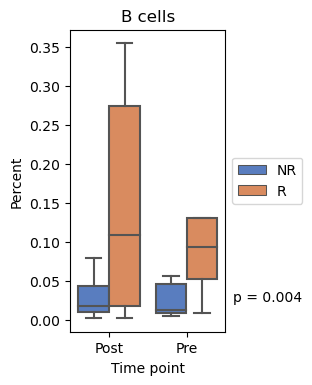

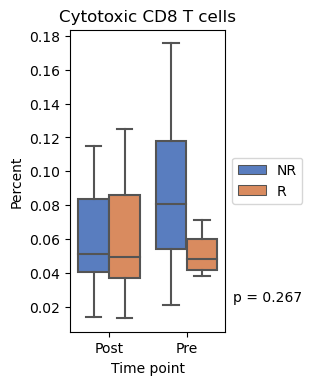

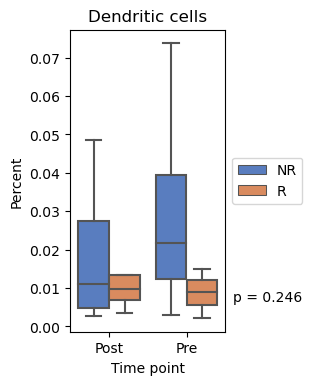

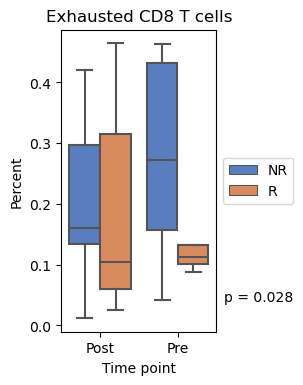

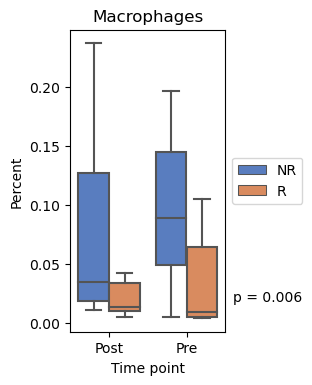

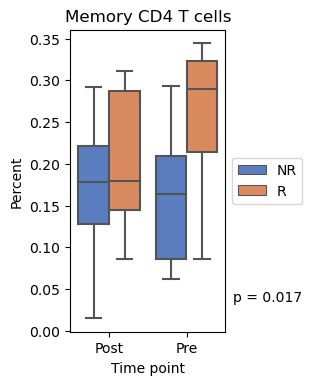

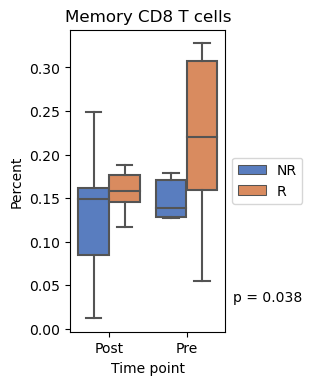

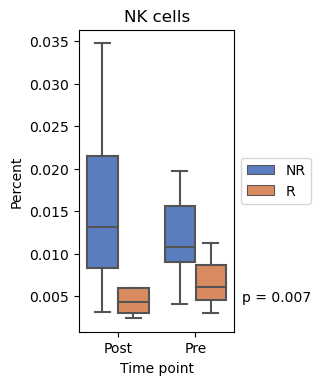

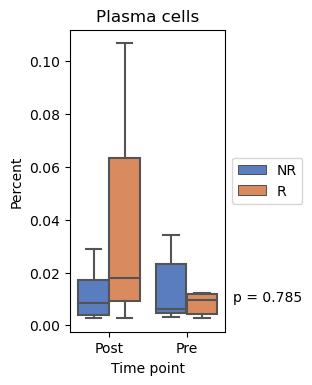

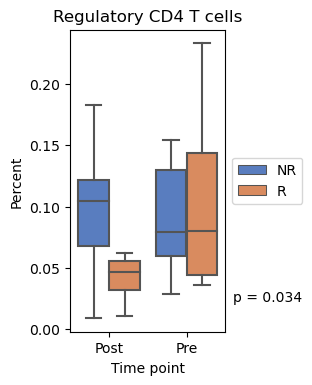

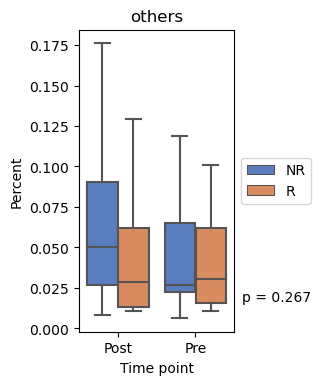

In [136]:
for a in res.cluster:
    pct_boxplot(a)

<AxesSubplot:xlabel='time_point', ylabel='percent'>

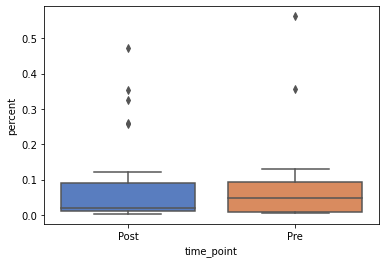

In [48]:
sns.boxplot(x="time_point", y="percent",
               data=cluster_pct.loc[cluster_pct.cell_type=='B cells'], 
               palette="muted")

<AxesSubplot:xlabel='time_point', ylabel='percent'>

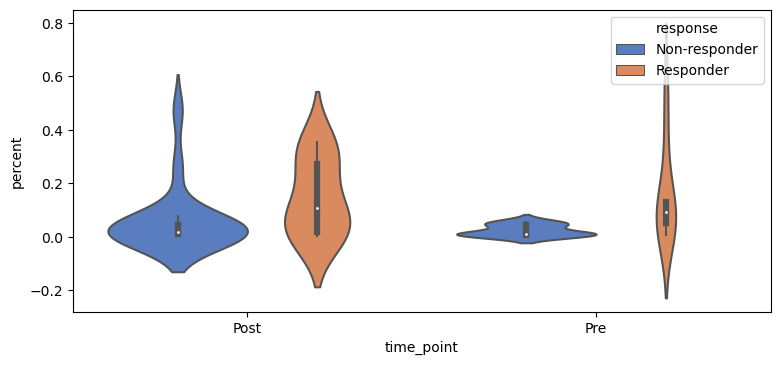

In [51]:
plt.figure(figsize=(9, 4), dpi=100)
sns.violinplot(x="time_point", y="percent", hue="response",
               data=cluster_pct.loc[cluster_pct.cell_type=='B cells'], 
               palette="muted")

<AxesSubplot:xlabel='time_point', ylabel='percent'>

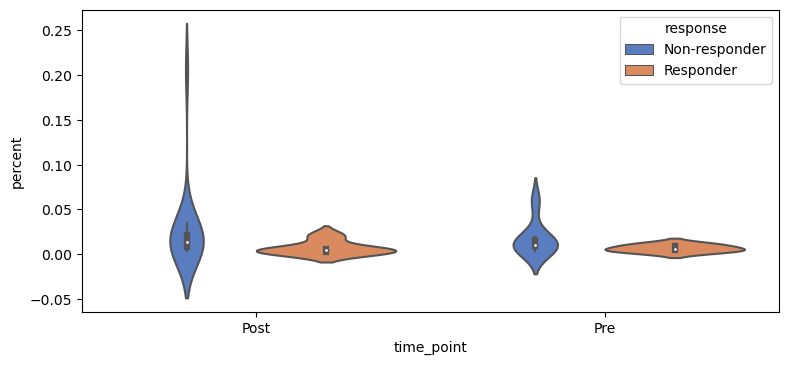

In [50]:
plt.figure(figsize=(9, 4), dpi=100)
sns.violinplot(x="time_point", y="percent", hue="response",
               data=cluster_pct.loc[cluster_pct.cell_type=='NK cells'], 
               palette="muted")

<AxesSubplot:xlabel='time_point', ylabel='percent'>

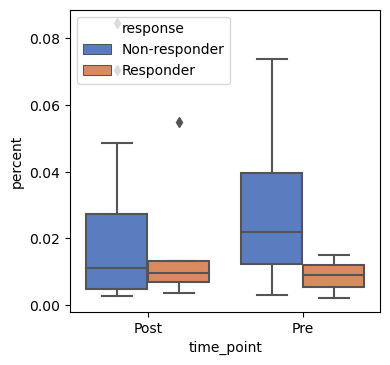

In [49]:
plt.figure(figsize=(4, 4), dpi=100)
sns.boxplot(x="time_point", y="percent", hue="response",
               data=cluster_pct.loc[cluster_pct.cell_type=='Dendritic cells'], 
               palette="muted")